In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [ ]:
def preprocess_data(order_reviews_df, order_payments_df):
    """
    Preprocessing data dari order reviews dan payments dengan analisis quartile
    """
    # Convert timestamp to datetime
    order_reviews_df['review_answer_timestamp'] = pd.to_datetime(order_reviews_df['review_answer_timestamp'])

    # Month and year extracts
    order_reviews_df['month_year'] = order_reviews_df['review_answer_timestamp'].dt.to_period('M')

    # Merge reviews and payments data based on order_id
    merged_df = pd.merge(order_reviews_df, order_payments_df, on='order_id', how='inner')

    # Grouping data by month
    monthly_data = merged_df.groupby('month_year').agg({
        'payment_value_rupiah': 'mean',
        'review_score': 'mean',
        'order_id': 'count'  # number of orders per month
    }).reset_index()

    monthly_data.columns = ['month_year', 'avg_payment', 'avg_rating', 'order_count']

    # Calculate quartiles
    quartiles = {}

    for column in ['avg_payment', 'avg_rating', 'order_count']:
        quartiles[column] = {
            'Q1': float(monthly_data[column].quantile(0.25)),
            'Q2': float(monthly_data[column].quantile(0.50)),
            'Q3': float(monthly_data[column].quantile(0.75)),
            'Q4': float(monthly_data[column].max()),
            'IQR': float(monthly_data[column].quantile(0.75) - monthly_data[column].quantile(0.25))
        }

        # Add quartile labels
        monthly_data[f'{column}_quartile'] = pd.qcut(
            monthly_data[column],
            q=4,
            labels=['Q1', 'Q2', 'Q3', 'Q4']
        )

    # Store quartiles in DataFrame attributes
    monthly_data.attrs['quartiles'] = quartiles

    return monthly_data


In [ ]:
def create_performance_labels(monthly_data):
    """
    Label performance based on business criteria with quartile consideration
    1 = Good performance (above median)
    0 = Performance needs improvement (below median)
    """
    # Get quartiles from stored attributes
    quartiles = monthly_data.attrs['quartiles']

    # Use Q2 (median) as threshold
    payment_threshold = quartiles['avg_payment']['Q2']
    rating_threshold = quartiles['avg_rating']['Q2']
    order_threshold = quartiles['order_count']['Q2']

    # Create binary indicators
    monthly_data['good_payment'] = (monthly_data['avg_payment'] > payment_threshold).astype(int)
    monthly_data['good_rating'] = (monthly_data['avg_rating'] > rating_threshold).astype(int)
    monthly_data['good_order_count'] = (monthly_data['order_count'] > order_threshold).astype(int)

    # Overall performance label
    monthly_data['performance_label'] = ((monthly_data['good_payment'] +
                                        monthly_data['good_rating'] +
                                        monthly_data['good_order_count']) >= 2).astype(int)

    return monthly_data


In [ ]:
def train_model(monthly_data):
    """
    Training the logistic regression model
    """
    X = monthly_data[['avg_payment', 'avg_rating', 'order_count']]
    y = monthly_data['performance_label']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled,
        y,
        test_size=0.2,
        random_state=42)

    model = LogisticRegression(random_state=42, C=1.0)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    results = {
        'model': model,
        'scaler': scaler,
        'accuracy': model.score(X_test, y_test),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'feature_importance': dict(zip(['Payment', 'Rating', 'Order Count'], model.coef_[0]))
    }

    return results


In [ ]:
def visualize_performance(monthly_data, results):
    """
    Create visualizations of business performance with quartile analysis
    """
    plt.figure(figsize=(20, 15))
    quartiles = monthly_data.attrs['quartiles']

    # Plot 1: Trend of average payment with quartiles
    plt.subplot(3, 2, 1)
    plt.plot(range(len(monthly_data)), monthly_data['avg_payment'], 'b-')
    for q_name, q_value in quartiles['avg_payment'].items():
        if q_name != 'IQR':
            plt.axhline(y=q_value, color='r', linestyle='--', alpha=0.5)
            plt.text(len(monthly_data)-1, q_value, f' {q_name}: {q_value:,.0f}')
    plt.title('Trend Pembayaran Rata-rata per Bulan dengan Quartiles')
    plt.xticks(range(len(monthly_data)), monthly_data['month_year'].astype(str), rotation=45)

    # Plot 2: Trend of average rating with quartiles
    plt.subplot(3, 2, 2)
    plt.plot(range(len(monthly_data)), monthly_data['avg_rating'], 'b-')
    for q_name, q_value in quartiles['avg_rating'].items():
        if q_name != 'IQR':
            plt.axhline(y=q_value, color='r', linestyle='--', alpha=0.5)
            plt.text(len(monthly_data)-1, q_value, f' {q_name}: {q_value:.2f}')
    plt.title('Trend Rating Rata-rata per Bulan dengan Quartiles')
    plt.xticks(range(len(monthly_data)), monthly_data['month_year'].astype(str), rotation=45)

    # Plot 3: Number of orders per month with quartiles
    plt.subplot(3, 2, 3)
    plt.bar(range(len(monthly_data)), monthly_data['order_count'])
    for q_name, q_value in quartiles['order_count'].items():
        if q_name != 'IQR':
            plt.axhline(y=q_value, color='r', linestyle='--', alpha=0.5)
            plt.text(len(monthly_data)-1, q_value, f' {q_name}: {q_value:.0f}')
    plt.title('Jumlah Order per Bulan dengan Quartiles')
    plt.xticks(range(len(monthly_data)), monthly_data['month_year'].astype(str), rotation=45)

    # Plot 4: Confusion Matrix
    plt.subplot(3, 2, 4)
    sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')

    plt.tight_layout()
    return plt

In [ ]:
def analyze_business_performance(order_reviews_df, order_payments_df):
    """
    Key functions for business performance analysis
    """
    monthly_data = preprocess_data(order_reviews_df, order_payments_df)
    monthly_data = create_performance_labels(monthly_data)
    results = train_model(monthly_data)
    plot = visualize_performance(monthly_data, results)

    return monthly_data, results, plot

In [ ]:
def print_quartile_details(monthly_data):
    """
    Print detailed quartile information for each metric
    """
    quartiles = monthly_data.attrs['quartiles']

    print("\n=== Quartile Details ===")
    for metric, values in quartiles.items():
        print(f"\n{metric.replace('_', ' ').title()} Quartiles:")
        for q_name, q_value in values.items():
            if q_name != 'IQR':
                print(f"{q_name}: {q_value:.2f}")
        print(f"IQR (Interquartile Range): {values['IQR']:.2f}")


=== Business Performance Analysis ===

Model Accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.50      0.67         2

    accuracy                           0.80         5
   macro avg       0.88      0.75      0.76         5
weighted avg       0.85      0.80      0.78         5


Factor Contribution:
Payment: 0.6839
Rating: 1.0218
Order Count: 1.0693

=== Quartile Details ===

Avg Payment Quartiles:
Q1: 2336770.77
Q2: 2469072.49
Q3: 2545636.96
Q4: 3788829.91
IQR (Interquartile Range): 208866.19

Avg Rating Quartiles:
Q1: 4.01
Q2: 4.12
Q3: 4.20
Q4: 4.41
IQR (Interquartile Range): 0.19

Order Count Quartiles:
Q1: 1462.00
Q2: 4365.00
Q3: 6525.00
Q4: 9087.00
IQR (Interquartile Range): 5063.00


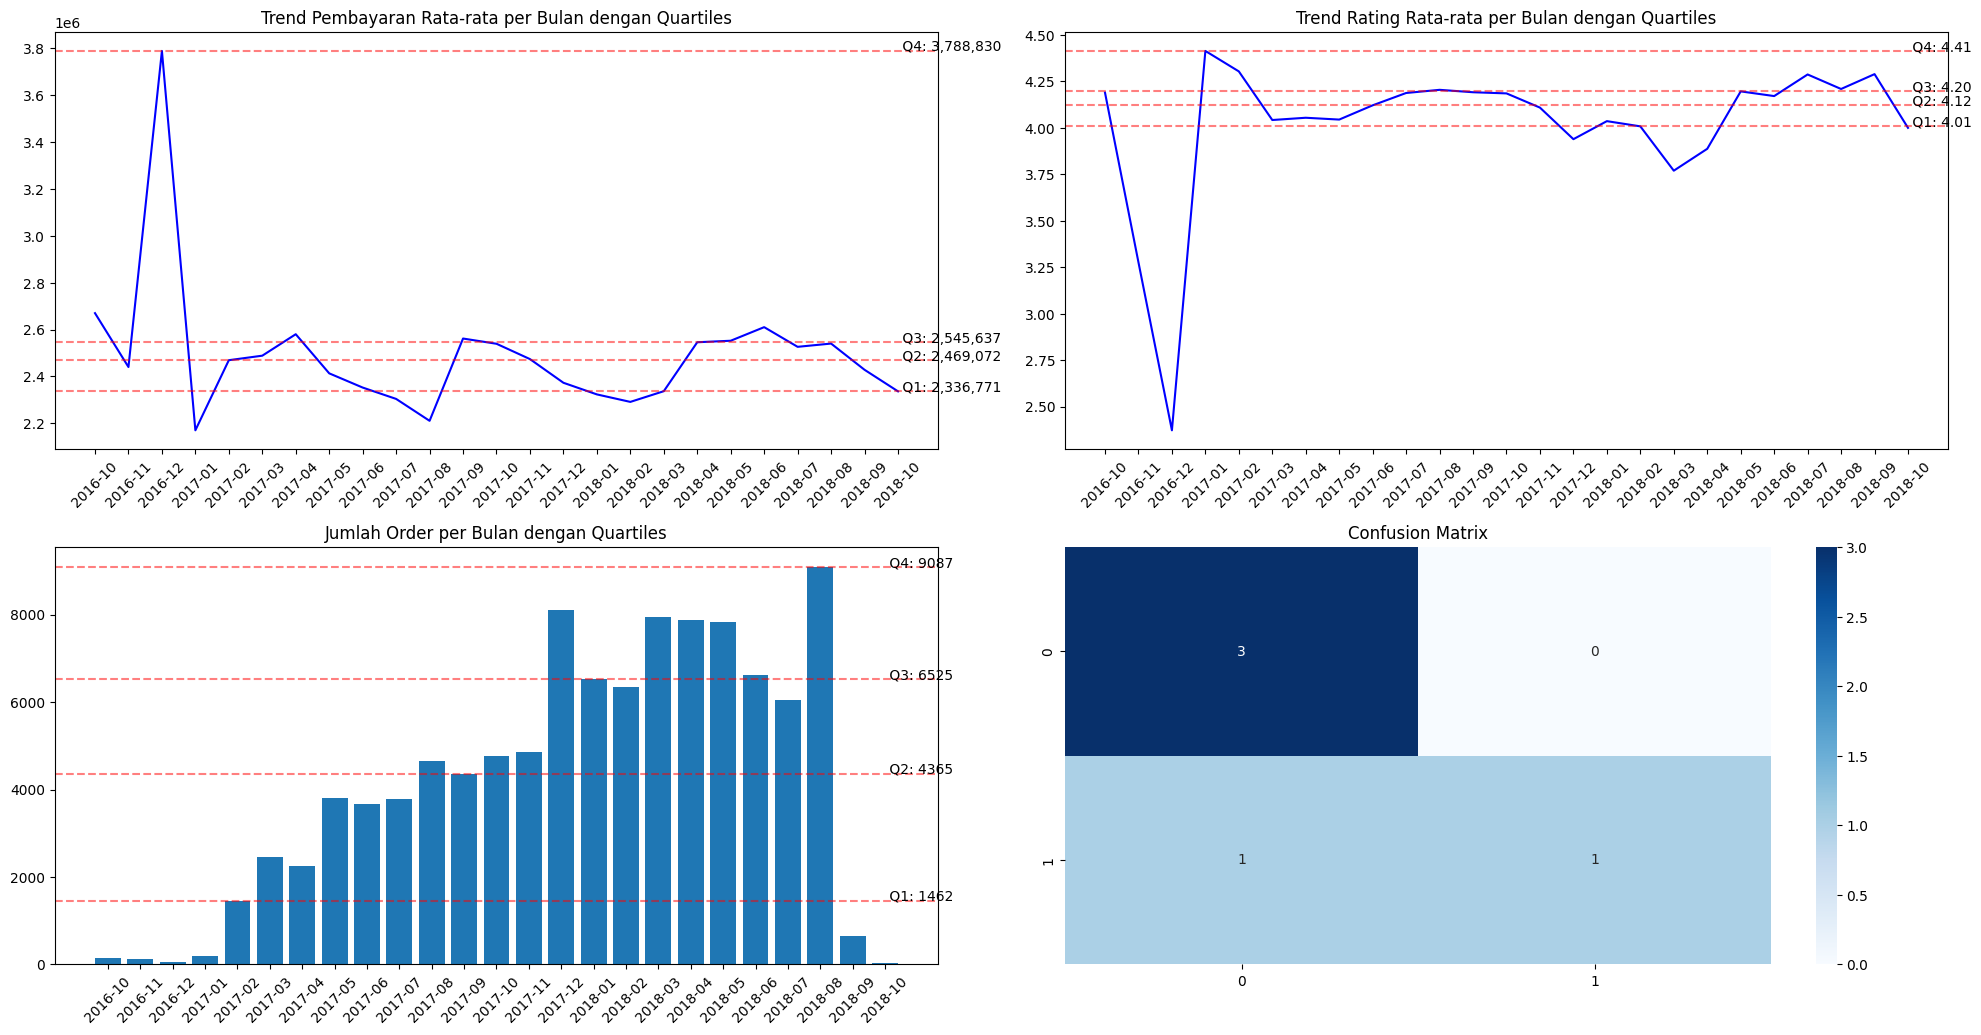

In [ ]:
# Read data directly from CSV
order_reviews_df = pd.read_csv('order_review.csv')
order_payments_df = pd.read_csv('order_payments_rupiah.csv')

# Performance analysis
monthly_data, results, plot = analyze_business_performance(order_reviews_df, order_payments_df)

# Print result
print("\n=== Business Performance Analysis ===")
print(f"\nModel Accuracy: {results['accuracy']:.2f}")
print("\nClassification Report:")
print(results['classification_report'])
print("\nFactor Contribution:")
for feature, importance in results['feature_importance'].items():
    print(f"{feature}: {importance:.4f}")

# Add this new function call
print_quartile_details(monthly_data)

# Tampilkan plot
plt.show()